In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import scipy
from glob import glob
import cartopy.crs as ccrs

%matplotlib inline

# Prepare input data 1979-2011

In [45]:
sst_filename = '/Users/leo/workspace/data/ERSST/v3b/netcdf/sst_all.nc'
ds_sst = xr.open_dataset(sst_filename)
ds_sst = ds_sst.squeeze('lev') # remove singleton dimension
ds_sst_tropical = ds_sst.sel(lat=slice(-20.,20), time=slice('1979','2011'))


# ERA INTERIM 200 HPA GEOPOTENTIAL HEIGHT
REANALYSIS = "ERA-I"
h250_filename = '/Users/leo/workspace/data/ERA-Interim/geopotential_flt_1979-2012.nc'
ds_h250_global = xr.open_dataset(h250_filename)

ds_h250 = ds_h250_global.sel(latitude=slice(88.5,0), time=slice('1979','2011'))
ds_h250['lat']=ds_h250['latitude']
ds_h250['lon']=ds_h250['longitude']

In [46]:
sst_ANN = ds_sst_tropical['sst'].groupby(ds_sst_tropical['time.year']).mean(dim='time')
sst_ANN_diff = sst_ANN - sst_ANN.mean(axis=0) # anomalies

(nt, nx, ny) = sst_ANN.shape
sst_ANN_flat = sst_ANN_diff.values.reshape(nt,nx*ny)
#sst_ANN_flat.shape

# no SST over land, these result in NaNs we need to filter out
mynan = np.isnan(sst_ANN_flat[0,:])
#mynan.shape

sst_ANN_flat_nonan = sst_ANN_flat[:,~mynan]
sst_ANN_flat_nonan.shape

(33, 2951)

In [47]:
h250_ANN = ds_h250['Z200'].groupby(ds_h250['time.year']).mean(dim='time')
h250_ANN_diff = h250_ANN - h250_ANN.mean(axis=0) # anomalies

h250_ANN_diff = h250_ANN_diff[:,::2,::2]
(nt2, nx2, ny2) = h250_ANN_diff.shape
print(nt2, nx2,ny2)

h250_ANN_flat = h250_ANN_diff.values.reshape(nt2,nx2*ny2)

# 0.5 degree resolution gives long array 
print(h250_ANN_flat.shape)

33 60 240
(33, 14400)


# Saving data as real*4 for use in Fortran

In [76]:
fname = 'sst_frompy.dat'
tmp = sst_ANN_flat_nonan.astype('float32', order='F')
tmp.tofile(fname)
print(os.path.getsize(fname), 4*np.prod(tmp.shape)) # should be identical

389532 389532


In [77]:
fname = 'z200_frompy.dat'
#tmp = h250_ANN_flat.astype('float32')
tmp = h250_ANN_diff.values[:,::-1,:]
print(tmp.shape)
tmp = tmp.astype('float32', order='F')

tmp.tofile(fname)
print(os.path.getsize(fname), 4*np.prod(tmp.shape)) # should be identical

(33, 60, 240)
1900800 1900800


## Testing the output

In [50]:
# first year ("record") , print some elements in SST 
sst_ANN_flat_nonan[0][0:10]

array([-0.20919765, -0.19285006, -0.16730941, -0.1524047 , -0.22446075,
       -0.39453935, -0.503206  , -0.46877948, -0.33670362, -0.29357254])

These values are the same as what Fortran reports (program print_binary.f90 / compiled as print_sst)

In [54]:
# first year ("record") , print first zonal band of Z200
h250_ANN_diff[0][1,:10].values

array([ 4.93554688,  4.97265625,  5.02246094,  5.06152344,  5.11328125,
        5.16015625,  5.2109375 ,  5.27636719,  5.31054688,  5.37304688], dtype=float32)

In [75]:
lon2d, lat2d = np.meshgrid(ds_h250.variables['lon'][::2], ds_h250.variables['lat'][::2])
lat2d[::-1,0]
#ds_h250.variables['lat'][::2]

array([  0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,  12. ,
        13.5,  15. ,  16.5,  18. ,  19.5,  21. ,  22.5,  24. ,  25.5,
        27. ,  28.5,  30. ,  31.5,  33. ,  34.5,  36. ,  37.5,  39. ,
        40.5,  42. ,  43.5,  45. ,  46.5,  48. ,  49.5,  51. ,  52.5,
        54. ,  55.5,  57. ,  58.5,  60. ,  61.5,  63. ,  64.5,  66. ,
        67.5,  69. ,  70.5,  72. ,  73.5,  75. ,  76.5,  78. ,  79.5,
        81. ,  82.5,  84. ,  85.5,  87. ,  88.5])

Latitude runs from high (88.5) to low (0 = equator), meaning that in the fortran code the y-coordinate equal to '1' means pole, and y equal to ny means tropics. I think this is in conflict with the assumptions made in the Fortran code, in particular the area weighting. There the highest weights are found for low y indices, and low weights for high y indices (see other notebook on "testing expressions"). 

Now the SVD Fortran program is executed.

# Analysis of output

In [62]:
nf = 8 # number of modes that is output by the Fortran program

nxy1 = len(h250_ANN_flat[0])
nxy2 = len(sst_ANN_flat_nonan[0])

fname = 'vec1.dat' # dat1 = gh = Z200 geopotential height
print(os.path.getsize(fname), 4*nf*nxy1) # should be identical
vec_z200 = np.fromfile(fname,dtype=np.float32)

fname = 'vec2.dat' # dat2 = olr = Z200 geopotential height
print(os.path.getsize(fname), 4*nf*nxy2) # should be identical
vec_sst = np.fromfile(fname,dtype=np.float32)
vec_sst = vec_sst.reshape(nf,nxy2)

460800 460800
94432 94432


In [67]:
imode = 0 # select mode number

# Convert 1d arrays to spatial patterns
# Display modal information
mc_sst = np.ma.masked_array(np.zeros(sst_ANN_flat.shape[1])) # no time dimension
mc_sst[~mynan] = - vec_sst[imode] # sign is arbitrary
mc_sst[mynan] = np.ma.masked
mc_sst = mc_sst.reshape(nx,ny) #* stt_ANN[0,:,:] # multiply with anomalies
print(mc_sst.shape)

# convert to DataArray to facilitate further processing
mc_sst_da = xr.DataArray(mc_sst, coords=[ds_sst_tropical['lat'], ds_sst_tropical['lon']], dims=['lat', 'lon'])

(21, 180)


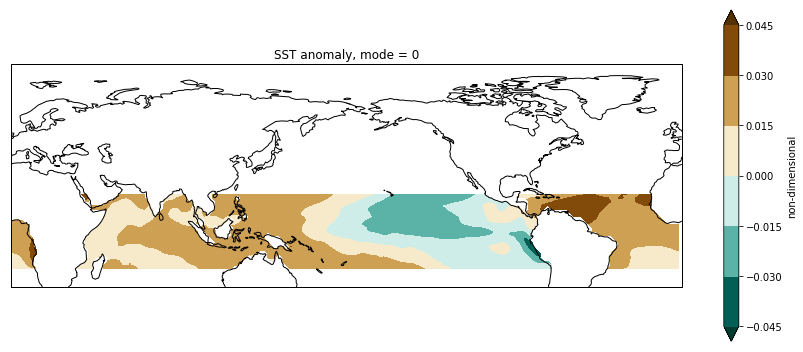

In [68]:
myproj = ccrs.PlateCarree()
myproj2 = ccrs.PlateCarree(central_longitude = -180.)
fig, axes = plt.subplots(1, figsize=(12,5),subplot_kw={'projection': myproj2})
cmap='BrBG_r'

def plot_mode_sst(ds, ax):    
    lon2d, lat2d = np.meshgrid(ds['lon'], ds['lat'])
    absmax = np.abs(ds).max().values
    levs = [-1,-0.7,-0.4,-0.1,0.1,0.4,0.7,1]
    levs = [-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4]
#    levs = np.linspace(-absmax, absmax, 11)
    
    cf = ax.contourf(lon2d, lat2d, ds.values, 
        transform = myproj, 
                     #levels=levs,
        cmap=cmap, extend='both')
    
    ax.coastlines()
    ax.set_global()
    ax.set_ylim(-30,90)

    ax.set_title('SST anomaly, mode = %d' % imode)
    cb = fig.colorbar(cf, ax=ax, label="non-dimensional")
    fig.tight_layout()
    #ax.set_extent([1, 360, -30, 90], myproj)
    
ax = axes
plot_mode_sst(mc_sst_da, ax)